# Quantum Fourier Transform

In [1]:
# importing qiskit and libraries
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, transpile, assemble, Aer, execute, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%matplotlib inline

## Generalised QFT Function

In [2]:
# Function to perform qft_rotations
def qft_rotations(circuit, n):
    # base condition
    # exit if circuit is empty
    if n == 0:
        return circuit
    n -= 1
    # Apply H-gate to qubits
    # starts from MSB(most significant bit)
    circuit.h(n)
    # loop to apply controlled rotations
    for qubit in range(n):
        circuit.cp(pi / 2 ** (n - qubit), qubit, n)
        # for each less significant bit, we need to apply
        # smaller-angled controlled rotations
    # Recursive call
    qft_rotations(circuit, n)
    # this recursive call will continue to apply rotations for nest MSB
        

In [3]:
# Function to perform swapping
def swap_registers(circuit, n):
    for qubit in range(n // 2):
        circuit.swap(qubit, n - 1 - qubit)
    return circuit    

In [4]:
# Function to make circuit
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

### Example for n = 4 for input x = 15(1111 in binary)

##### 1- Using simulator

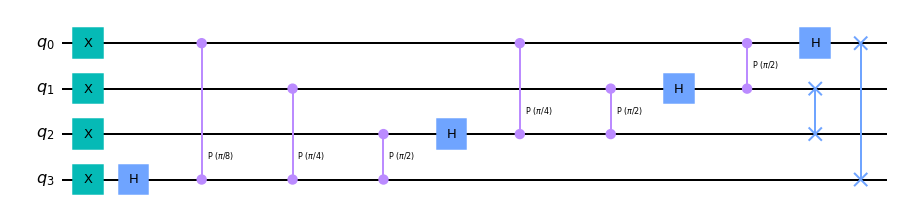

In [5]:
n = 4
qc = QuantumCircuit(n)
for qubit in range(n):
    qc.x(qubit)
qc = qft(qc, n)
qc.draw(output = 'mpl')

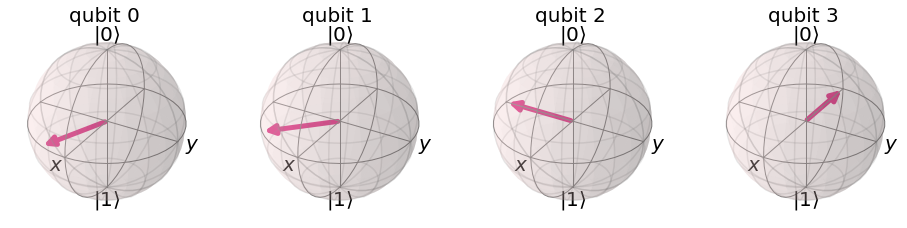

In [6]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

##### 2- On real quantum Computer
 - All the qubits are in superposition states because of H-gate.
 - Results could be random.
 - So we will perform verify using reverse operations.
 - Starting from |$\tilde x$>.
 - Output should be |x>

In [7]:
# Function for Inverse Fourier Transform
def inverse_qft(circuit, n):
    # first create QFT circuit of the correct size
    qft_circ = qft(QuantumCircuit(n), n)
    # then take inverse of the circuit
    invqft_circ = qft_circ.inverse()
    # and add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[: n])
    return circuit.decompose()
# decompose() allows us to see the individual gates

Now, let's put the qubit in state |$\tilde x$> where x = 15

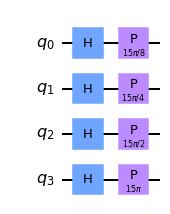

In [8]:
nqubits = 4
number = 15
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
    qc.p((number * pi * (2 ** (qubit + 1))) / 2 **n, qubit)
qc.draw(output = 'mpl')  

To check whether we've created correct state in fourire basis or not:

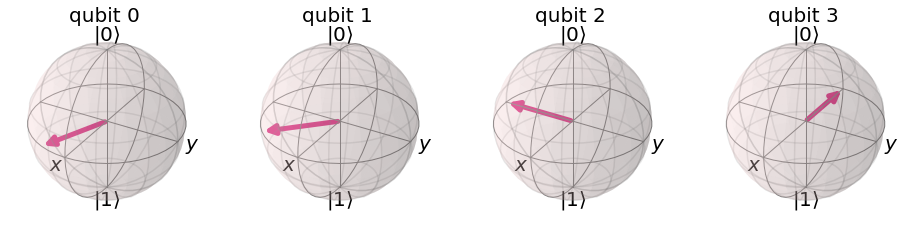

In [9]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

Finally let's apply our inverse QFT:

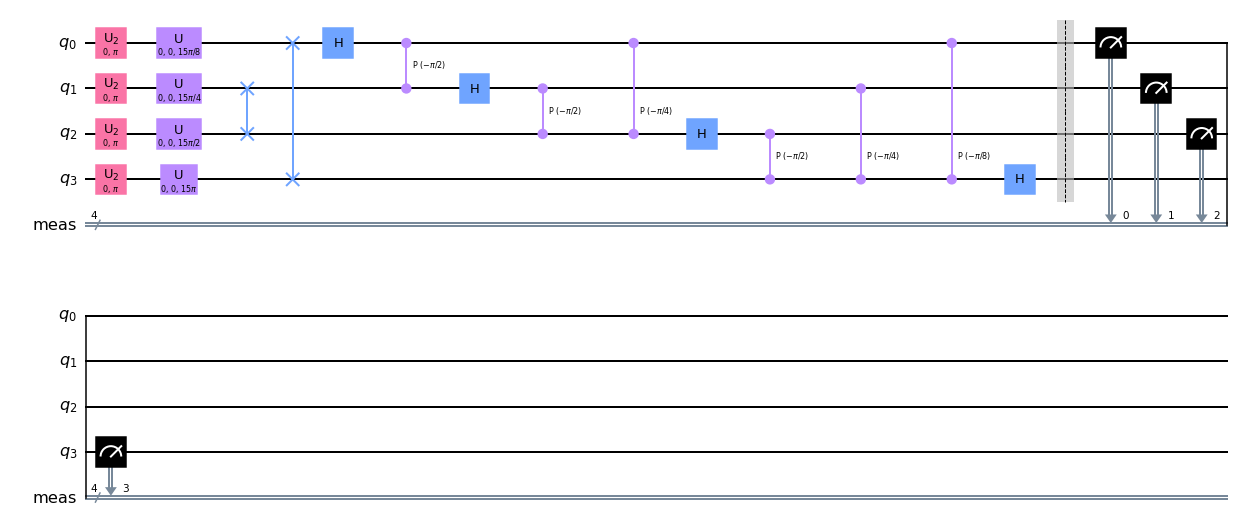

In [10]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw(output = 'mpl')

In [11]:
# Load our saved IBMQ account
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [12]:
provider = IBMQ.get_provider('ibm-q')

In [13]:
qcomp = provider.get_backend('ibmq_santiago')
job = execute(qc, backend = qcomp)
job_monitor(job, interval = 2)

Job Status: job has successfully run


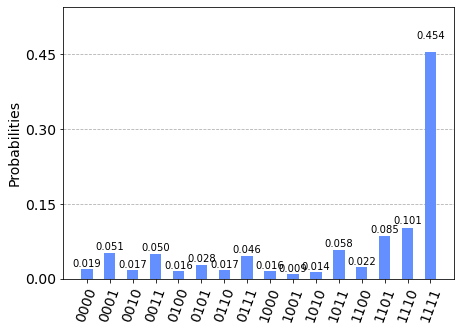

In [14]:
results = job.result()
ans = results.get_counts()
plot_histogram(ans)

We(hopefully) see that the highest probability outcome is 1111.